<a href="https://colab.research.google.com/github/KubaSiwiec/plant_recognition/blob/main/Plant_recognition_pt_no_sep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to use

To make code below work properly:
 

1.   Download leafsnap dataset from [Leafsnap website](http://leafsnap.com/dataset/),
2.   place leafsnap dataset of your Google Drive at location: /content/gdrive/MyDrive/leafsnap_data,

1.   use the 
[data processing and orginizing script](https://colab.research.google.com/drive/1S803Ho4BLyO6zfwxHRzw27u9_ucFNrKY?usp=sharing)








# Get data

Mount Google drive to Colab to access data

In [39]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Import necessary modules

In [40]:
from __future__ import print_function, division
 
from IPython.display import clear_output, display
 
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy

import torchvision.transforms.functional as TF
from skimage.feature import local_binary_pattern, hog, canny, corner_fast
from PIL import Image

from sklearn.metrics import f1_score

# import models
from torchvision.models.resnet import resnet18, resnet34, resnet50, resnet101, resnet152, resnext50_32x4d, resnext101_32x8d, wide_resnet50_2, wide_resnet101_2
from torchvision.models.vgg  import vgg16
from torchvision.models.inception import inception_v3
from torchvision.models.googlenet import googlenet
from torchvision.models.densenet import densenet121
from torchvision.models.alexnet import alexnet
from torchvision.models.mobilenetv3 import mobilenet_v3_small, mobilenet_v3_large
from torchvision.models.squeezenet import squeezenet1_1


from typing import Type, Any, Callable, Union, List, Optional, Dict, cast, Tuple, OrderedDict

import collections
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import date

# Define configuration class

In [41]:
class Cfg(object):
    '''
    This is a class consisting of configuration for the future run
    '''

    def __init__(self, model_type, data_transform, learning_rate = 0.02, number_of_epochs = 50, scheduler_step_size = 20, criterion = torch.nn.CrossEntropyLoss(), lbp_radius = 3, save_model = False):
        self.model_type = model_type
        self.data_transform = data_transform
        self.learning_rate = learning_rate
        self.number_of_epochs = number_of_epochs
        self.scheduler_step_size = scheduler_step_size
        self.criterion = criterion
        self.lbp_radius = lbp_radius
        self.save_model = save_model
        
        

    def set_optimizer(self, model_ft):
        self.optimizer  = optim.SGD(model_ft.parameters(), lr=self.learning_rate, momentum=0.9)
    def set_scheduler(self, optimizer_ft):
        self.scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=self.scheduler_step_size, gamma=0.1)

    def set_model_type(self, model_type):
        self.model_type = model_type
    def set_data_transform(self, data_transform):
        self.data_transform = data_transform
    def set_learning_rate(self, learning_rate):
        self.learning_rate = learning_rate
    def set_scheduler_step_size(self, scheduler_step_size):
        self.scheduler_step_size = scheduler_step_size
    
    
    def __repr__(self):
        d_t_repr = (self.data_transform + '_rad' +  str(self.lbp_radius)) if self.data_transform in ['lbp', 'lbp_3'] else self.data_transform
        return "{}\t{}\t{}\t{}\t{}".format(self.model_type, d_t_repr, self.learning_rate, self.number_of_epochs, self.scheduler_step_size)

Set config before running rest of the code

In [42]:
cfg = Cfg('resnet18_1chan', 'lbp', 0.02, 1, criterion = torch.nn.CrossEntropyLoss())

Print resources information

In [43]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jul  5 12:07:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    30W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Feature extraction functions

In [44]:
def local_binary_pattern_3channels(img, radius, n_points):
    r, g, b = img.split()
    lbp_r = local_binary_pattern(r, radius, n_points)
    lbp_g = local_binary_pattern(g, radius, n_points)
    lbp_b = local_binary_pattern(b, radius, n_points)
    return (np.dstack((lbp_r,lbp_g,lbp_b)) / np.amax(np.dstack((lbp_r,lbp_g,lbp_b))) * 255).astype(np.uint8)

In [45]:
def canny_3channels(img):
    r, g, b = img.split()
    lbp_r = canny(np.asarray(r))
    lbp_g = canny(np.asarray(g))
    lbp_b = canny(np.asarray(b))
    return (np.dstack((lbp_r,lbp_g,lbp_b)) / np.amax(np.dstack((lbp_r,lbp_g,lbp_b))) * 255).astype(np.uint8)

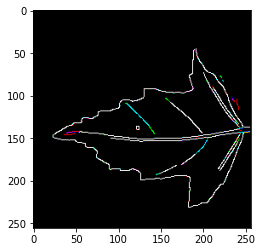

In [46]:
im = Image.open('/content/gdrive/MyDrive/leafsnap_data/leafsnap-dataset-resized-no-sep/acer_ginnala/13291762510376.jpg')
plt.imshow(im)
plt.imshow(Image.fromarray(canny_3channels(im)))

In [47]:
# w podobny sposób trzeba pisać nowe transformacje
class Local_binary_pattern(object):
      def __init__(self, radius):
          assert isinstance(radius, int)
          self.radius = radius
          self.n_points = radius * 8

      def __call__(self, img):
          """
          Args:
              img (PIL Image): Image to be scaled.
          Returns:
              PIL Image: Rescaled image.
          """
          return Image.fromarray(local_binary_pattern(img, self.radius, self.n_points))
 
      def __repr__(self):
          return self.__class__.__name__ + '()'


In [48]:
class Local_binary_pattern3(object):
      def __init__(self, radius):
          assert isinstance(radius, int)
          self.radius = radius
          self.n_points = radius * 8

      def __call__(self, img):
          """
          Args:
              img (PIL Image): Image to be scaled.
          Returns:
              PIL Image: Rescaled image.
          """
          return Image.fromarray(local_binary_pattern_3channels(img, self.radius, self.n_points))
 
      def __repr__(self):
          return self.__class__.__name__ + '()'

In [49]:
class Canny3(object):

      def __call__(self, img):
          """
          Args:
              img (PIL Image): Image to be scaled.
          Returns:
              PIL Image: Rescaled image.
          """
          return Image.fromarray(canny_3channels(img))
 
      def __repr__(self):
          return self.__class__.__name__ + '()'

In [50]:
# w podobny sposób trzeba pisać nowe transformacje
class TrippleGrayscale(object):

      def __call__(self, img):
          """
          Args:
              img (PIL Image): Image to be scaled.
          Returns:
              PIL Image: Rescaled image.
          """

          

          return Image.fromarray(local_binary_pattern(img, self.radius, self.n_points))
 
      def __repr__(self):
          return self.__class__.__name__ + '()'


In [51]:
class Hog(object):
      def __call__(self, img):
          """
          Args:
              img (PIL Image): Image to be scaled.
          Returns:
              PIL Image: Rescaled image.
          """
          hog_descriptor = hog(img, visualize = False)
          return hog_descriptor
 
      def __repr__(self):
          return self.__class__.__name__ + '()'

PIL images are not writable, thus to prevent warnings, convertion to numpy before converting to torch.Tensor is necessary

In [52]:
class ToNumpy(object):
    def __call__(self, sample):
        return np.array(sample)

# Transforms

In [53]:
# transforms
data_transform = {
    'original': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(),
        ToNumpy(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))        
    ]),
    'grayscale': transforms.Compose([
        transforms.Grayscale(),
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(),
        ToNumpy(),
        transforms.ToTensor()
    ]),
    'lbp': transforms.Compose([
        transforms.Grayscale(),
        Local_binary_pattern(cfg.lbp_radius),
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(),
        ToNumpy(),
        transforms.ToTensor(),
    ]),
    'grayscale3': transforms.Compose([
        transforms.Grayscale(3),
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(),
        ToNumpy(),
        transforms.ToTensor()
    ]),
    'lbp3': transforms.Compose([
        Local_binary_pattern3(cfg.lbp_radius),
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(),
        ToNumpy(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
    ]),
    'canny3': transforms.Compose([
        Canny3(),
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(),
        ToNumpy(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
    ]),
    # there is necessity to extract histograms later
    'hog': transforms.Compose([
        # transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(),
        ToNumpy(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        lambda x: np.rollaxis(x.numpy(), 0, 3)
    ])
}


# Define data loaders for lazy image loading

In [54]:
def get_data_loaders(cfg):
    data = {x: datasets.ImageFolder('/content/gdrive/MyDrive/leafsnap_data/{}'.format(x), transform = data_transform[cfg.data_transform]) for x in ['leafsnap-dataset-resized-no-sep']}
    data_length = len(data['leafsnap-dataset-resized-no-sep'])
    train_size = int(data_length * 0.7)
    val_size = int(data_length * 0.2)
    test_size = data_length - train_size - val_size
    plant_dataset = {}
    plant_dataset['train'], plant_dataset['validation'], plant_dataset['test'] = torch.utils.data.random_split(data['leafsnap-dataset-resized-no-sep'], [train_size, val_size, test_size])
    dataloaders = {x: DataLoader(plant_dataset[x], batch_size = 32, num_workers = 4, shuffle = True, drop_last = True) for x in ['train', 'validation', 'test']}
    dataset_size = {x: len(plant_dataset[x]) for x in ['train', 'validation', 'test']}
    print('Training dataset size: {}'.format(dataset_size['train']))
    print('Validation dataset size: {}'.format(dataset_size['validation']))
    print('Test dataset size: {}'.format(dataset_size['test']))
    return dataloaders, dataset_size, data

# Imshow

In [55]:
def imshow(image):
  if isinstance(image, torch.Tensor):
    image = image.numpy().transpose((1,2,0))
  else:
    image = np.array(image).transpose((1,2,0))
  # unnormalize
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image = std * image + mean
  image = np.clip(image, 0, 1)

  # plot
  fig, ax = plt.subplots(1,1, figsize=(15,15))
  plt.imshow(image)
  ax.axis('off')




# Set device

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# F1-score calculations

In [57]:
def f1score(y_true, y_pred):
      tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
      tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
      fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
      fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

      precision = tp / (tp + fp + self.epsilon)
      recall = tp / (tp + fn + self.epsilon)

      f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
      f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
      print(tp, tn, fp, fn, precision, recall)
      # return 1 - f1.mean()

In [58]:
def get_weighted_f1(f1_arr, labels):
    labels_count = collections.Counter(labels)
    ordered_labels_count = collections.OrderedDict(sorted(labels_count.items()))

    all_images_count = sum(ordered_labels_count.values())
    print(all_images_count)
    f1_weighted = 0
    for idx, (key, value) in enumerate(ordered_labels_count.items()):
        f1_weighted += value * f1_arr[idx]
    f1_weighted /= all_images_count
    print(f1_weighted)
    return f1_weighted

# Display functions for training

In [59]:
def progress_bar(samples_already_processed, total_samples):
    nb_spaces = int(((total_samples - samples_already_processed) / total_samples) * 70)
    nb_eq_signs = int((samples_already_processed / total_samples) * 70)
    bar = '||' + '=' * nb_eq_signs + '>' + ' ' * nb_spaces + '||    ' + str(samples_already_processed) + '/' + str(total_samples)
    return bar

In [60]:
def print_train_info(model):
    print('Model: {}'.format(model))
    print('\n' * 10 + '-' * 10 + '\t' + '-' * 10 + '\t' + '-' * 10 + '\n' + 
          '|' + ' ' * 10 + '\t' + ' ' * 10 + '\t' + ' ' * 10  + '|' + '\n' +
          '|' + ' ' * 10 + '\tTRAINING\t' + ' ' * 10  + '|' + '\n' + 
          '|' + ' ' * 10 + '\t' + ' ' * 10 + '\t' + ' ' * 10  + '|' + '\n' +
          '-' * 10 + '\t' + '-' * 10 + '\t' + '-' * 10 + '\n\n\n')

# Training

In [61]:
def train_model(model, cfg: Cfg, print_epoch_info: str = 'detailed'):
    print_train_info(model)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epochs_info = 'First of {} epochs started:'.format(cfg.number_of_epochs)
    epoch_progress_bar = ''
    training_progress_bar = ''
    epochs_disp = display(epochs_info, display_id = True)
    print('Epochs:')
    training_progress_display = display(training_progress_bar, display_id = True)
    print('\nImages processed:')
    epoch_progress_disp = display(epochs_disp, display_id = True)
    print('\n\n\n\n\n')

    train_acc = np.array([])
    val_acc = np.array([])

    for epoch in range(cfg.number_of_epochs):
        training_progress_display.update(progress_bar(epoch + 1, cfg.number_of_epochs))
        start_epoch_time = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                dataset = 'train'
                model.train()  # Set model to training mode
            else:
                dataset = 'validation'
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_index, (inputs, labels) in enumerate(dataloaders[dataset]):
                if cfg.data_transform == 'hog':
                    inputs = hog(inputs, visualize = False)
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                cfg.optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = cfg.criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        cfg.optimizer.step()

                # statistics
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if print_epoch_info == 'detailed':
                    epoch_time = time.time() - start_epoch_time
                    epoch_progress_bar = progress_bar(batch_index * dataloaders[dataset].batch_size + 1, dataset_size[dataset])
                    epoch_progress_disp.update(epoch_progress_bar)
            if phase == 'train':
                cfg.scheduler.step()

            epoch_loss = running_loss / dataset_size[dataset]
            epoch_acc = running_corrects.double() / dataset_size[dataset]

            if phase == 'train':
                train_acc = np.append(train_acc, epoch_acc.cpu().numpy())
            if phase == 'validation':
                val_acc = np.append(val_acc, epoch_acc.cpu().numpy())
            if print_epoch_info in ['detailed']:
                epochs_info = 'Epoch {}, {}, Loss: {:.4f} Acc: {:.4f} Time: {}'.format(
                    epoch, phase, epoch_loss, epoch_acc, epoch_time)
                # clear_output(wait=False)
            if print_epoch_info in ['general']:
                epochs_info = 'Epoch {}, {} Loss: {:.4f} Acc: {:.4f}'.format(
                    epoch, phase, epoch_loss, epoch_acc)
            epochs_disp.update(epochs_info)

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, time_elapsed, train_acc, val_acc

# Testing

In [62]:
def test_model(model):
    start_time = time.time()

    
    dataset = 'test'
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    running_corrects5 = 0

    y_real = np.array([])
    y_pred = np.array([])

    # Iterate over data.
    for batch_index, (inputs, labels) in enumerate(dataloaders[dataset]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            _, preds5 = torch.topk(outputs, 5, 1)
        # statistics
        # clear_output(wait=False)
        y_real = np.append(y_real, labels.data.cpu().numpy())
        y_pred = np.append(y_pred, preds.cpu().numpy())
        
        running_corrects += torch.sum(preds == labels.data)
        for i, single_pred in enumerate(preds5):
            running_corrects5 += 1 if (labels.data[i] in single_pred) else 0

        print("{}/{} images used for testing.".format(batch_index * dataloaders[dataset].batch_size + 1, dataset_size[dataset]))
        # clear_output(wait=False)

    test_acc = running_corrects.double() / dataset_size[dataset]
    test_acc5 = float(running_corrects5 / dataset_size[dataset])

    print('Test accuracy: {:.4f}\n'.format(test_acc))
    print('Top 5 test accuracy: {:.4f}\n'.format(test_acc5))
    f1 = f1_score(y_real, y_pred, average=None)
    print("F score: {}".format(f1))

    return test_acc, f1, y_real, test_acc5

# Get results

In [63]:
def plot_training_acc(train_acc, val_acc, cfg: Cfg):
    plots_folder = "/content/gdrive/MyDrive/leafsnap_training_accuracy"
    Path(plots_folder).mkdir(parents=True, exist_ok=True)

    plot_save_path = "{}/{}_{}_{}_{}_{}.png".format(plots_folder, cfg.model_type, cfg.data_transform, cfg.learning_rate, cfg.scheduler_step_size, date.today())

    plt.figure(figsize=(12, 8), dpi=60)
    plt.subplot(211)
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy')
    plt.plot(train_acc)
    plt.hlines(train_acc.max(), 0, cfg.number_of_epochs - 1, colors=None, linestyles='dashed', label=str(train_acc.max()))
    plt.text(0, train_acc.max(), round(train_acc.max(),3), ha='right', va='center')
    plt.subplot(212)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')   
    plt.plot(val_acc)
    plt.hlines(val_acc.max(), 0, cfg.number_of_epochs - 1, colors=None, linestyles='dashed', label=str(val_acc.max()))
    plt.text(0, val_acc.max(), round(val_acc.max(),3), ha='right', va='center')

    plt.savefig(plot_save_path)

    

# NN models

In [64]:
class LSTM_network():
    def __init__(self):
      pass

Modify torchvision resnet architectures to make them able to process single channel images:

In [65]:
class ResNet_1chan(models.resnet.ResNet):

    def __init__(self, block, layers, num_classes = 187, width_per_group = 4, groups = 32):
        self.inplanes = 64
        super(ResNet_1chan, self).__init__(block, layers)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        
def _resnet(
    arch: str,
    block: Type[Union[models.resnet.BasicBlock, models.resnet.Bottleneck]],
    layers: List[int],
    progress: bool,
    **kwargs: Any
) -> ResNet_1chan:
    model = ResNet_1chan(block, layers, **kwargs)
    return model


def resnet18_1chan(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet_1chan:
    kwargs['num_classes'] = len(class_names)
    return _resnet('resnet18', models.resnet.BasicBlock, [2, 2, 2, 2], progress, **kwargs)

def resnet34_1chan(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet_1chan:
    kwargs['num_classes'] = len(class_names)
    return _resnet('resnet34', models.resnet.BasicBlock, [3, 4, 6, 3], progress,
                   **kwargs)

def resnet50_1chan(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet_1chan:
    kwargs['num_classes'] = len(class_names)
    return _resnet('resnet50', models.resnet.Bottleneck, [3, 4, 6, 3], progress,
                   **kwargs)


def resnet101_1chan(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet_1chan:
    kwargs['num_classes'] = len(class_names)
    return _resnet('resnet101', models.resnet.Bottleneck, [3, 4, 23, 3], progress,
                   **kwargs)


def resnet152_1chan(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet_1chan:
    kwargs['num_classes'] = len(class_names)
    return _resnet('resnet152', models.resnet.Bottleneck, [3, 8, 36, 3], progress,
                   **kwargs)

def resnext50_32x4d_1chan(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet_1chan:
    kwargs['num_classes'] = len(class_names)
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', models.resnet.Bottleneck, [3, 4, 6, 3],
                   progress, **kwargs)


def resnext101_32x8d_1chan(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet_1chan:
    kwargs['num_classes'] = len(class_names)
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', models.resnet.Bottleneck, [3, 4, 23, 3],
                   progress, **kwargs)


def wide_resnet50_2_1chan(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet_1chan:
    kwargs['num_classes'] = len(class_names)
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', models.resnet.Bottleneck, [3, 4, 6, 3],
                   progress, **kwargs)


def wide_resnet101_2_1chan(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet_1chan:
    kwargs['num_classes'] = len(class_names)
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', models.resnet.Bottleneck, [3, 4, 23, 3],
                   progress, **kwargs)

VGG16 for 1 channel input:

In [66]:
from torchvision.models.vgg import VGG

# cfgs for different vgg versions
cfgs: Dict[str, List[Union[str, int]]] = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers_1chan(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def _vgg_1chan(arch: str, vgg_cfg: str, batch_norm: bool, pretrained: bool, progress: bool, **kwargs: Any) -> VGG:
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers_1chan(cfgs[vgg_cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def vgg16_1chan(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    return _vgg_1chan('vgg16_1chan', 'D', False, False, progress, **kwargs)

Customization for densenet to process one-channel input

In [67]:
class DenseNet_1chan(models.densenet.DenseNet):

    def __init__(self,
        growth_rate: int = 32,
        block_config: Tuple[int, int, int, int] = (6, 12, 24, 16),
        num_init_features: int = 64,
        bn_size: int = 4,
        drop_rate: float = 0,
        num_classes: int = 1000,
        memory_efficient: bool = False
    ) -> None:
        super(DenseNet_1chan, self).__init__(growth_rate,
        block_config,
        num_init_features,
        bn_size,
        drop_rate,
        num_classes,
        memory_efficient)
        
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(1, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

def _densenet_1chan(
    arch: str,
    growth_rate: int,
    block_config: Tuple[int, int, int, int],
    num_init_features: int,
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> DenseNet_1chan:
    model = DenseNet_1chan(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model

def densenet121_1chan(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> DenseNet_1chan:
    return _densenet_1chan('densenet121_1chan', 32, (6, 12, 24, 16), 64, False, False,
                     **kwargs)

Redefine alexnet to process single channel images:

In [68]:
from torchvision.models.alexnet import AlexNet
class AlexNet_1chan(AlexNet):

    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet_1chan, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

def alexnet_1chan(**kwargs: Any) -> AlexNet:
    model = AlexNet_1chan(**kwargs)
    return model

In [69]:
class SqueezeNet_1chan(models.squeezenet.SqueezeNet):

    def __init__(
        self,
        num_classes: int = 1000
    ) -> None:
        super(SqueezeNet_1chan, self).__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(64, 16, 64, 64),
            Fire(128, 16, 64, 64),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(128, 32, 128, 128),
            Fire(256, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(256, 48, 192, 192),
            Fire(384, 48, 192, 192),
            Fire(384, 64, 256, 256),
            Fire(512, 64, 256, 256),
        )

def _squeezenet_1chan(**kwargs: Any) -> SqueezeNet_1chan:
    model = SqueezeNet_1chan(version, **kwargs)
    return model

def squeezenet1_1_1chan(**kwargs: Any) -> SqueezeNet_1chan:
    return _squeezenet_1chan(**kwargs)

Define model:

In [70]:
def get_model(cfg):
    # Get model name from configuration and call function creating it
    model_type = globals().get(cfg.model_type)
    print(model_type)
    model_ft = model_type(num_classes = len(class_names))

    cfg.set_optimizer(model_ft)
    cfg.set_scheduler(cfg.optimizer)

    # model_ft = resnet18_1chan()
    # num_ftrs = model_ft.fc.in_features
    # Here the size of each output sample is set to len(class_names).
    # model_ft.fc = torch.nn.Linear(num_ftrs, len(class_names))
    return model_ft.to(device)

Test model - resturn test accuracy and the array of F1-scores for each label and Y-real for purpose of computing weighted F1

# Visualize images

In [71]:
def show_images(dataloaders):
    images, labels = iter(dataloaders['train']).next()
    out = torchvision.utils.make_grid(images, nrow = 8)
    imshow(out)
    print(labels)

def print_histograms(dataloaders):
    imgs, labels = iter(dataloaders['train']).next()
    # imshow(imgs[0])
    for img in imgs.numpy():
        histogram, hog_img = hog(img, visualize = True, pixels_per_cell= (16, 16), cells_per_block= (2, 2))
        print(len(histogram))
        print(labels)
        imshow(hog_img)

def visualize(cfg: Cfg, dataloaders):
    if cfg.data_transform == 'hog':
        print_histograms(dataloaders)
    else:
        show_images(dataloaders)

In [72]:
def get_class_names(data):
    class_names = data['leafsnap-dataset-resized-no-sep'].classes
    print(class_names)
    print(len(class_names))
    return class_names

# Save results

In [73]:
def write_results(cfg, test_acc, test_acc5, f1_weighted, training_time):
    with open("/content/gdrive/MyDrive/results_top5.tsv", "a+") as results_file:
        if os.stat("/content/gdrive/MyDrive/results_top5.tsv").st_size == 0:
            results_file.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format("model_type", "data_transform", "learning_rate", "number_of_epochs", "scheduler_step_size", "training_time", "test_accuracy", "top_5_test_accuracy", "F1-score"))
        results_file.write("{}\t{}\t{}\t{}\t{}\n".format(cfg, training_time, test_acc, test_acc5, f1_weighted))

# Execution pipeline

In [74]:
def run():
    '''
    This is the run() funtion. It is responsible for executing the whole program
    '''
    transforms = ['original', 'grayscale', 'lbp3', 'canny3', 'hog']
    # transforms = ['lbp3']
    # transforms = ['grayscale']
    for transform in transforms:
        cfg.set_data_transform(transform)
        global dataloaders, dataset_size, class_names
        dataloaders, dataset_size, data = get_data_loaders(cfg)
        class_names = get_class_names(data)
        visualize(cfg, dataloaders)
        if cfg.data_transform == 'original':
            models = ['vgg16', 
                      'resnet18', 
                      'resnet34', 
                      'resnet50', 
                      'resnet101', 
                      'resnet152', 
                      'resnext50_32x4d', 
                      'resnext101_32x8d', 
                      'wide_resnet50_2', 
                      'wide_resnet101_2',
                      'inception_v3',
                      'googlenet',
                      'densenet121',
                      'alexnet',
                      'mobilenet_v3_small', 
                      'mobilenet_v3_large',
                      'squeezenet1_1']
            # models = [#'inception_v3',
            #           # 'googlenet',
            #           'densenet121',
            #           'alexnet',
            #           'mobilenet_v3_small', 
            #           'mobilenet_v3_large',
            #           'squeezenet1_1']
        else:
            # models = ['resnet18_1chan', 'resnet34_1chan', 'resnet50_1chan', 'resnet101_1chan', 'resnet152_1chan', 'resnext50_32x4d_1chan', 'resnext101_32x8d_1chan', 'wide_resnet50_2_1chan', 'wide_resnet101_2_1chan', 'vgg16_1chan', 'densenet121_1chan']
            models = [ 'vgg16', 
                      'resnet18', 
                      'resnet34', 
                      'resnet50', 
                      'resnet101', 
                      'resnet152', 
                      'resnext50_32x4d', 
                      'resnext101_32x8d', 
                      'wide_resnet50_2', 
                      'wide_resnet101_2',
                      'densenet121',
                      'alexnet',
                      'mobilenet_v3_small', 
                      'mobilenet_v3_large',
                      'squeezenet1_1']
        
        for nn_model in models:
            print("Transform: {}, model: {}".format(transform, nn_model))
            cfg.set_model_type(nn_model)
            model_ft = get_model(cfg)
            model_ft, time_elapsed, train_acc, val_acc = train_model(model_ft, cfg, print_epoch_info = 'detailed')
            plot_training_acc(train_acc, val_acc, cfg)
            test_acc, f1_each_label, labels, test_acc5 = test_model(model_ft)
            f1_weighted = get_weighted_f1(f1_each_label, labels)
            write_results(cfg, test_acc, test_acc5, f1_weighted, time_elapsed)
            print("Trained {} on {} pictures".format(cfg.model_type, cfg.data_transform))
            if cfg.save_model:
                model_save_folder = '/content/gdrive/MyDrive/plant_recognition_models'
                Path(model_save_folder).mkdir(parents=True, exist_ok=True)
                model_save_path = model_save_folder + '/model_' + cfg.model_type + '_' + cfg.data_transform + '_' + str(date.today())
                torch.save(model_ft.state_dict(), model_save_path)

In [ ]:
# In the line below it is possible to choose the starting configuration 
cfg = Cfg('resnet18_1chan', 'grayscale', 0.02, 30, lbp_radius=3, save_model = True)
run()


Training dataset size: 20148
Validation dataset size: 5756
Test dataset size: 2880
['acer_campestre', 'acer_ginnala', 'acer_griseum', 'acer_negundo', 'acer_palmatum', 'acer_pensylvanicum', 'acer_platanoides', 'acer_pseudoplatanus', 'acer_rubrum', 'acer_saccharinum', 'acer_saccharum', 'aesculus_flava', 'aesculus_glabra', 'aesculus_hippocastamon', 'aesculus_pavi', 'ailanthus_altissima', 'albizia_julibrissin', 'amelanchier_arborea', 'amelanchier_canadensis', 'amelanchier_laevis', 'asimina_triloba', 'betula_alleghaniensis', 'betula_jacqemontii', 'betula_lenta', 'betula_nigra', 'betula_populifolia', 'broussonettia_papyrifera', 'carpinus_betulus', 'carpinus_caroliniana', 'carya_cordiformis', 'carya_glabra', 'carya_ovata', 'carya_tomentosa', 'castanea_dentata', 'catalpa_bignonioides', 'catalpa_speciosa', 'celtis_occidentalis', 'celtis_tenuifolia', 'cercidiphyllum_japonicum', 'cercis_canadensis', 'chamaecyparis_pisifera', 'chamaecyparis_thyoides', 'chionanthus_retusus', 'chionanthus_virginicus

'Epoch 0, validation, Loss: 5.0303 Acc: 0.0208 Time: 240.59332585334778'

Epochs:


'||====>                                                                 ||    2/30'


Images processed:


'||===================================>                                  ||    10305/20148'

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
